In [1]:
%pylab inline
from matplotlib import pylab as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne 

## Multinomial factor model

We have the following matrix factor model:

$$X = UV^T$$

for $U$ an $N\times K$ matrix and $V$ a $P\times K$ matrix. We observe a matrix $Y$ of the same shape as $X$, where each column

$$Y_{\cdot,j} \sim \text{Multinomial}(n_j ; \pi_{1j},\dots,\pi_{Nj}),$$
$$\pi_{i,j} = \frac{g(X_{ij})}{\sum_{i'}g(X_{i'j})}, $$
$$g(z) = \frac{z}{1-e^{-C z}}.$$

We use the following prior:

$$U_{ij} \sim N\left(0,\left(\gamma_{ij}\prod_{\ell=1}^j \delta_\ell\right)^{-1}\right)$$
$$V_{ij}\sim N(0,1)$$
$$\gamma_{ij} \sim \text{Gamma}(1/2,1/2)$$
$$\delta_1 \sim \text{Gamma}(a_1,1)$$
$$\delta_\ell \sim \text{Gamma}(a_2,1) \quad \ell\geq 2$$
$$a_1 \sim \text{Gamma}(1,b)$$
$$a_2 \sim \text{Gamma}(1,b).$$

Our variational approximation $q$ of the posterior $p$ makes the rows of $U$ and $V$ independent multivariate normals, and all the other parameters, which are strictly positive, independent and log-normal. We call the variational parameters collectively $\lambda$.

The Evidence Lower Bound (ELBO) is

$$\mathcal L(\lambda) = E_q(\log p) - E_q(\log q) = E_q(\log p) + H(q). $$

We have 

$$H(q) = C + \sum_{i=1}^N \frac{1}{2}\log |\Sigma_{U_i}| + \sum_{j=1}^P \frac{1}{2}\log |\Sigma_{V_j}| 
          + \sum_{\ell=1}^K \sum_{i=1}^N \log(\sigma_{\gamma_{i \ell}}) + \mu_{\gamma_{i \ell}} 
          + \sum_{\ell=1}^K \log(\sigma_{\delta_\ell}) + \mu_{\delta_\ell} 
          + \log(\sigma_{a_1}) + \mu_{a_1}
          + \log(\sigma_{a_2}) + \mu_{a_2}
          + \log(\sigma_{s}) + \mu_{s}
$$         

where $C$ collects constants that do not depend on the variational parameters. Now,

$$\nabla_\lambda \mathcal L(\lambda) = \nabla_\lambda E_q(\log p) + \nabla_\lambda H(q). $$

Let all the normal parameters be transforms of a standard normal variate, e.g. $U_i = \mu_{U_i} + \Sigma_{U_i}^{1/2}Z_{U_i}$, or $\log(\delta_\ell) = \mu_{\delta_\ell} + \sigma_{\delta_\ell}z_{\delta_\ell}$, and let $E$ denote the expectation with respect to these standard variates. The first term in the gradient can be written 

$$ \nabla_\lambda E_q(\log p) = E( \nabla_\lambda \log p ),$$

where on the right hand side, we take the expectation with respect to the standard variates and write $\log p$ as a function of the variational parameters:

$$ \log p = \sum_{i=1}^N\sum_{j=1}^P Y_{ij}\log g(U_i V_j^T) - \sum_{j=1}^P n_j \log\left( \sum_{i=1}^N g(U_iV_j^T) \right)
            - \frac{1}{2}\sum_{i=1}^n\sum_{j = 1}^k  U_{ij}^2\gamma_{ij}\prod_{\ell=1}^j \delta_\ell
            - \frac{1}{2}\sum_{i=1}^p\sum_{j = 1}^k  V_{ij}^2 \qquad \qquad \qquad  \qquad \qquad \qquad  \qquad $$
$$          - b a_1 - b a_2 -\frac{1}{2}\sum_{i\leq N, j\leq P} \left( \log \gamma_{ij} - \gamma_{ij}\right)
            - \log\Gamma(a_1) + (a_1-1)\log\delta_1 -\delta_1 
            + \sum_{1<\ell\leq K}\left( \log\Gamma(a_2) +(a_2-1) \log\delta_\ell -\delta_\ell \right).
$$

The expectation of the gradient of the log posterior will be estimated using a single sample of the standard variates.

In [64]:
# Syntactic sugar for shared variable
Shared = lambda shape,name: theano.shared(value = np.ones(shape,dtype=theano.config.floatX),
                                          name=name,borrow=True) 

# Define dimensions
N = 31
P = 900
K = 10

# Read data. In this example, X = 1 . 1^T, a rank 1 matrix 
Y = theano.shared(np.ones((N,P),dtype=theano.config.floatX))
colSumsY = Shared((P),"colSumsY")
colSumsY.set_value(Y.sum(0).eval())

# Define variational parameters
mU = Shared((N,K),"mU")
mV = Shared((P,K),"mV")
sU = Shared((N,K,K),"sU")                     # Factors for covariance 
sV = Shared((P,K,K),"sV")                     # matrices of rows of U and V
sU.set_value([np.eye(K) for i in range(N)])
sV.set_value([np.eye(K) for i in range(P)])
mDelta = Shared((K),"mDelta")
sDelta = Shared((K),"sDelta")
mGamma = Shared((N,K),"mGamma")
sGamma = Shared((N,K),"sGamma")
ma1 = Shared((1),"ma1")
sa1 = Shared((1),"sa1")
ma2 = Shared((1),"ma2")
sa2 = Shared((1),"sa2")

# Define a stream of random numbers
srng = T.shared_randomstreams.RandomStreams(seed=234)

# Define model parameters 
## Standard versions:
zU = srng.normal((N,K))
zV = srng.normal((P,K))
zGamma = srng.normal((N,K))
zDelta = srng.normal([K])
za1 = srng.normal([1])
za2 = srng.normal([1])
## Non-standard versions:
U = mU+T.batched_dot(zU,sU) 
V = mV+T.batched_dot(zV,sV)
Gamma = T.exp(mGamma + sGamma*zGamma)   # The variables Gamma, Delta,
Delta = T.exp(mDelta + sDelta*zDelta)   # a1, a2 have a log-normal
a1 = T.exp(ma1 + sa1*za1)               # variational posterior
a2 = T.exp(ma2 + sa2*za2)

# Define lists
vParams = [mU,mV,sU,sV,mDelta,sDelta,mGamma,sGamma,ma1,sa1,ma2,sa2]
mParams = [U,V,Gamma,Delta,a1,a2]
            
def Entropy(N,P,K,vParams):
    """
    Defines entropy of variational posterior (up to a constant)
    """
    mU,mV,sU,sV,mDelta,sDelta,mGamma,sGamma,ma1,sa1,ma2,sa2 = vParams
    outputs, updates = theano.scan(lambda i,y: T.log(T.nlinalg.Det()(T.dot(sU[i,:,:].T,sU[i,:,:])))/2+y,
                                   sequences = [dict(input=np.arange(N) ,taps=[-1])], 
                                   outputs_info = [dict(initial= np.float64(0) ,taps=[-1])] )
    outputs, updates = theano.scan(lambda i,y: T.log(T.nlinalg.Det()(T.dot(sV[i,:,:].T,sV[i,:,:])))/2+y,
                                   sequences = [dict(input=np.arange(P) ,taps=[-1])], 
                                   outputs_info = [dict(initial= outputs[-1] ,taps=[-1])] )
    ent = outputs[-1]
    ent += T.log(sGamma).sum() + mGamma.sum() \
          + T.log(sDelta).sum() + mDelta.sum() \
          + T.log(T.abs_(sa1)) + ma1 + T.log(T.abs_(sa2)) + ma2 
    return(ent)
        
def LogP(N,P,K,Y,colSumsY,mParams,vParams):
    """
    Defines the log posterior (up to a constant)
    """
    mU,mV,sU,sV,mDelta,sDelta,mGamma,sGamma,ma1,sa1,ma2,sa2 = vParams
    U,V,Gamma,Delta,a1,a2 = mParams
    X = T.dot(U,V.T)
    C = 10
    gX = X/(1-T.exp(-C*X))
    colSumsgX = gX.sum(0)
    b = 1
    logP = (Y*T.log(gX)).sum() - (colSumsY*T.log(colSumsgX)).sum() \
           - (T.sqr(U)*Delta.cumprod()*Gamma).sum()/2 \
           + T.log(Delta.cumprod()*Gamma).sum()/2 \
           - (T.sqr(V)).sum()/2 \
           - b*a1 - b*a2 - T.log(Gamma).sum()/2 - Gamma.sum()/2 \
           - T.gammaln(a1) + (a1-1)*T.log(Delta[0]) - Delta[0] \
           - T.gammaln(a2)*(K-1) + (a2-1)*T.log(Delta[1:]).sum() - Delta[1:].sum()
    return(logP)
            
def ELBO(N,P,K,Y,colSumsY,mParams,vParams):
    return(LogP(N,P,K,Y,colSumsY,mParams,vParams)[0]+Entropy(N,P,K,vParams)[0])

In [65]:
# Lasagne does gradient descent, so the cost we minimize is the *negative* ELBO 
elbo = ELBO(N,P,K,Y,colSumsY,mParams,vParams)
vParamUpdates = lasagne.updates.adadelta(-elbo,vParams)
AdaDeltaStep = theano.function(inputs=[],updates=vParamUpdates)

In [75]:
%%time
counter = 0
ELBOlist = []
keepUpdating = True
while keepUpdating:
    
    AdaDeltaStep()
    
    # Estimate ELBO by Monte Carlo every 20 steps
    if counter%20==0:
        ELBOlist.append(np.mean([elbo.eval() for i in range(10)]))
    
    keepUpdating = False if counter>1000 else True
    counter += 1

CPU times: user 6min 20s, sys: 7.78 s, total: 6min 28s
Wall time: 6min 55s


In [77]:
# This is the posterior mean of Delta
np.exp(mDelta.eval()+sDelta.eval()**2/2)

array([ 2.44154162,  2.311278  ,  2.40817429,  2.40349732,  2.41192618,
        2.38590525,  2.44575349,  2.44289037,  2.48464908,  2.48459975])

In [68]:
# The mean of X is close to the true X
np.dot(mU.eval(),mV.eval().T)

array([[ 8.04829596,  8.05546054,  8.37359998, ...,  7.87788281,
         8.36167578,  5.7664313 ],
       [ 8.07656255,  8.07837467,  8.38509252, ...,  7.89146641,
         8.36566693,  5.80323758],
       [ 8.04970809,  8.05542265,  8.3645958 , ...,  7.87020741,
         8.34952925,  5.77279111],
       ..., 
       [ 8.1830075 ,  8.18733659,  8.50895918, ...,  8.00549261,
         8.49163247,  5.86667251],
       [ 8.24122355,  8.25441854,  8.57181177, ...,  8.06034917,
         8.55230223,  5.9153675 ],
       [ 8.2107357 ,  8.21374517,  8.5352055 , ...,  8.03261625,
         8.52326759,  5.88254115]])

In [69]:
# And the factors reveal the rank 1 structure 
#hinton(mU.eval())
mU.eval()

array([[ 1.38845174,  0.98363814,  0.71655763,  0.74579697,  0.77182108,
         0.82246237,  0.80068246,  0.81665071,  0.85516943,  0.87931216],
       [ 1.46519904,  1.03859793,  0.7582725 ,  0.7385082 ,  0.73399096,
         0.78149679,  0.7910896 ,  0.79953141,  0.77057903,  0.86973514],
       [ 1.36163418,  1.04149056,  0.79691246,  0.77666126,  0.73510692,
         0.76798357,  0.79999806,  0.80600678,  0.79618947,  0.87449376],
       [ 1.43682389,  0.9897087 ,  0.76948881,  0.78894732,  0.73899309,
         0.77527919,  0.78251617,  0.82241355,  0.83671124,  0.80721959],
       [ 1.43152301,  1.03556852,  0.75527794,  0.73642459,  0.77194458,
         0.81399182,  0.8030899 ,  0.82402702,  0.78299409,  0.82232172],
       [ 1.38121452,  1.09088395,  0.85641505,  0.77013069,  0.74020504,
         0.8113771 ,  0.83676533,  0.76634448,  0.76820869,  0.86788238],
       [ 1.42747012,  1.00860426,  0.7631624 ,  0.74695039,  0.76330871,
         0.76269485,  0.79705427,  0.84257619

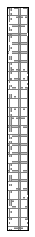

In [11]:
hinton(mV.eval())

In [105]:
# We can check that the variance s of the noise in X is small
s.eval()

array([ 0.00115952])

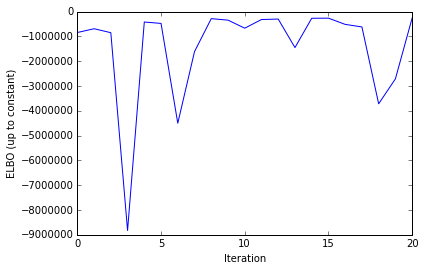

In [76]:
# Finally, we plot the ELBO against iteration
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ELBOlist[30:])
ax.set_xlabel("Iteration")
ax.set_ylabel("ELBO (up to constant)")

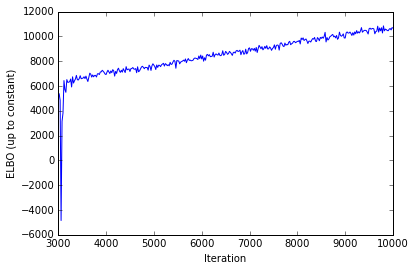

In [118]:
# Zooming into the last ~7000 iterations
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0,10001,20)[-7000/20:],ELBOlist[-7000/20:])
ax.set_xlabel("Iteration")
ax.set_ylabel("ELBO (up to constant)")

### Hinton Plotting of NumPy arrays

In [61]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([y - size / 2, x - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [25]:
lp = LogP(N,P,K,Y,colSumsY,mParams,vParams)

In [46]:
lp.eval()

array([-790206.29494543])

In [43]:
T.grad(lp[0],[mU])[0]

NullTypeGradError: tensor.grad encountered a NaN. This variable is Null because the grad method for input 3 (<RandomStateType>) of the for{cpu,scan_fn} op is mathematically undefined. Depends on a shared variable

In [36]:
X = T.dot(U,V.T)
C = 10
gX = X/(1-T.exp(-C*X))
colSumsgX = gX.sum(0)

In [52]:
multi = Y*T.log(gX).sum() - colSumsY*T.log(colSumsgX).sum()

In [53]:
multi.eval()

array([[-21028.13110352, -21028.13110352, -21028.13110352, ...,
        -21028.13110352, -21028.13110352, -21028.13110352],
       [-21028.13110352, -21028.13110352, -21028.13110352, ...,
        -21028.13110352, -21028.13110352, -21028.13110352],
       [-21028.13110352, -21028.13110352, -21028.13110352, ...,
        -21028.13110352, -21028.13110352, -21028.13110352],
       ..., 
       [-21028.13110352, -21028.13110352, -21028.13110352, ...,
        -21028.13110352, -21028.13110352, -21028.13110352],
       [-21028.13110352, -21028.13110352, -21028.13110352, ...,
        -21028.13110352, -21028.13110352, -21028.13110352],
       [-21028.13110352, -21028.13110352, -21028.13110352, ...,
        -21028.13110352, -21028.13110352, -21028.13110352]])